In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.neighbors import NearestCentroid,NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer,LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.utils.extmath import randomized_svd
from IPython.display import display
from numpy import linalg as la
from scipy.sparse import csr_matrix
pd.set_option('display.max_colwidth',None)
import os
import pickle as pk

In [ ]:
users_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1JsWiGOpXta47kyP9QQMH7rskZAtmkZxg',sep=";",on_bad_lines="skip",encoding='latin-1')
ratings_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1YrOExeh28DHW3djtgPdAxjaYOTaQDtFl',sep=";",on_bad_lines="skip",encoding='latin-1')
books_df = pd.read_csv("https://drive.google.com/uc?export=download&id=1AsnxW_v4-J8F3ulQZF3Cvxtuk_13O5Jd",sep=";",on_bad_lines='skip',encoding = 'latin-1',low_memory = False)

In [ ]:
print("Books dataframe shape: " , books_df.shape)
print("Ratings dataframe shape: " , ratings_df.shape)
print("Users dataframe shape: " , users_df.shape)

Books dataframe shape:  (271360, 8)
Ratings dataframe shape:  (1149780, 3)
Users dataframe shape:  (278858, 3)


In [ ]:
books_df.head(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [ ]:
ratings_df.head(5)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
users_df.head(5)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


PRE-PROCESSING

In [ ]:
users_df.head(5)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


#### From the above result, we can see that location consists of city, state, country
#### So, we will filter out the attribute having data less than 3 values

In [ ]:
# Getting the indices of location which is not equal to 3
drop_indeces = users_df[users_df['Location'].str.split(",").str.len() != 3].index

In [ ]:
## Dropping the above indices
users_df = users_df.drop(index = drop_indeces)


In [ ]:
## Computing the count whose location has all 3 values
(users_df['Location'].str.split(",").str.len()==3).value_counts()

Location
True    277348
Name: count, dtype: int64

In [ ]:
users_df[['City','State','Country']] = users_df['Location'].str.strip().str.split(",",expand = True,n=2)

In [ ]:
users_df['City'] = users_df['City'].str.strip()
users_df['State'] = users_df['State'].str.strip()
users_df['Country'] = users_df['Country'].str.strip()

In [ ]:
users_df.head()

,User-ID,Location,Age,City,State,Country
0,1,"nyc, new york, usa",NaN,nyc,new york,usa
1,2,"stockton, california, usa",18.0,stockton,california,usa
2,3,"moscow, yukon territory, russia",NaN,moscow,yukon territory,russia
3,4,"porto, v.n.gaia, portugal",17.0,porto,v.n.gaia,portugal
4,5,"farnborough, hants, united kingdom",NaN,farnborough,hants,united kingdom


#### Dropping column 'Location' as it is split into (City,State,Country) columns

In [ ]:
users_df = users_df.drop('Location',axis = 1)
users_df

,User-ID,Age,City,State,Country
0,1,NaN,nyc,new york,usa
1,2,18.0,stockton,california,usa
2,3,NaN,moscow,yukon territory,russia
3,4,17.0,porto,v.n.gaia,portugal
4,5,NaN,farnborough,hants,united kingdom
...,...,...,...,...,...
278853,278854,NaN,portland,oregon,usa
278854,278855,50.0,tacoma,washington,united kingdom
278855,278856,NaN,brampton,ontario,canada
278856,278857,NaN,knoxville,tennessee,usa


In [ ]:
users_df['Age'].unique()

array([ nan,  18.,  17.,  61.,  26.,  14.,  25.,  19.,  46.,  55.,  32.,
        24.,  20.,  34.,  23.,  51.,  31.,  21.,  44.,  30.,  57.,  43.,
        37.,  41.,  54.,  42.,  50.,  39.,  53.,  47.,  36.,  28.,  35.,
        13.,  58.,  49.,  38.,  45.,  62.,  63.,  27.,  33.,  29.,  66.,
        40.,  15.,  60.,   0.,  79.,  22.,  16.,  65.,  59.,  48.,  72.,
        56.,  67.,   1.,  80.,  52.,  69.,  71.,  73.,  78.,   9.,  64.,
       103., 104.,  12.,  74.,  75., 231.,   3.,  76.,  83.,  68., 119.,
        11.,   2.,  70.,  77.,  93.,   8.,   7.,   4.,  81., 114., 230.,
       239.,  10.,   5., 148., 151.,   6., 101., 201.,  96.,  84.,  82.,
        90., 123., 244., 133.,  91., 128.,  94.,  85., 141., 110.,  97.,
       219.,  86., 124.,  92., 175., 172., 209., 212., 237.,  87., 162.,
       100., 156., 136.,  95.,  89., 106.,  99., 108., 210.,  88., 199.,
       147., 168., 132., 159., 186., 152., 102., 116., 200., 115., 226.,
       137., 207., 229., 138., 109., 105., 228., 18

## Also we are considering age group between 10 to 90 to get more appropriate data

In [ ]:
users_df[~users_df['Age'].between(10,90) & ~users_df['Age'].isnull()]['Age'].unique()

array([  0.,   1.,   9., 103., 104., 231.,   3., 119.,   2.,  93.,   8.,
         7.,   4., 114., 230., 239.,   5., 148., 151.,   6., 101., 201.,
        96., 123., 244., 133.,  91., 128.,  94., 141., 110.,  97., 219.,
       124.,  92., 175., 172., 209., 212., 237., 162., 100., 156., 136.,
        95., 106.,  99., 108., 210., 199., 147., 168., 132., 159., 186.,
       152., 102., 116., 200., 115., 226., 137., 207., 229., 138., 109.,
       105., 228., 183., 204.,  98., 223., 113., 208., 157., 111., 146.,
       118., 220., 143., 140., 189., 127.])

Text(0, 0.5, 'Frequency')

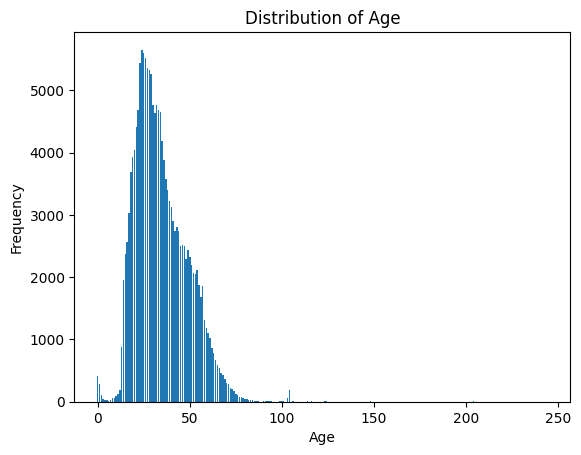

In [ ]:
ages_graph_params = users_df.groupby('Age').size()
plt.bar(ages_graph_params.index,ages_graph_params.values)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

#### Filtering the age group as mentioned

In [ ]:
users_to_omit = ~users_df['Age'].between(10,90) & ~users_df['Age'].isnull()
users_df.loc[users_to_omit] = np.nan
users_df['Age'].sort_values().unique()

array([10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22.,
       23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35.,
       36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48.,
       49., 50., 51., 52., 53., 54., 55., 56., 57., 58., 59., 60., 61.,
       62., 63., 64., 65., 66., 67., 68., 69., 70., 71., 72., 73., 74.,
       75., 76., 77., 78., 79., 80., 81., 82., 83., 84., 85., 86., 87.,
       88., 89., 90., nan])

In [ ]:
users_df.head()

,User-ID,Age,City,State,Country
0,1.0,NaN,nyc,new york,usa
1,2.0,18.0,stockton,california,usa
2,3.0,NaN,moscow,yukon territory,russia
3,4.0,17.0,porto,v.n.gaia,portugal
4,5.0,NaN,farnborough,hants,united kingdom


In [ ]:
users_df['Age'].mean()

34.729518290474466

#### Imputing age column with the mean age value of 34

In [ ]:
null_age = users_df['Age'].isnull()
users_df.loc[null_age,'Age'] = users_df['Age'].mean()

<BarContainer object of 82 artists>

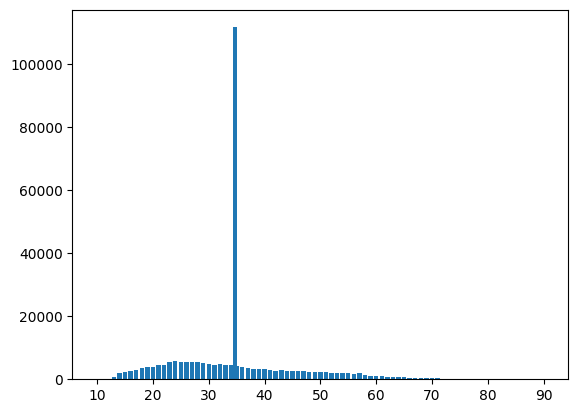

In [ ]:
ages_graph_params = users_df.groupby('Age').size()
plt.bar(ages_graph_params.index,ages_graph_params.values)


In [ ]:
users_df.head()

,User-ID,Age,City,State,Country
0,1.0,34.729518,nyc,new york,usa
1,2.0,18.000000,stockton,california,usa
2,3.0,34.729518,moscow,yukon territory,russia
3,4.0,17.000000,porto,v.n.gaia,portugal
4,5.0,34.729518,farnborough,hants,united kingdom


In [ ]:
users_df['Age'] = users_df['Age'].astype('int')

In [ ]:
users_df['Age'].sort_values().unique()

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90])

#### Column country has garbage and reduntant values

In [ ]:
users_df['Country'].sort_values().unique()

array(['', '"', '&#20013;&#22269;', '&#32654;&#22269;', '*', '-',
       '-------', '.', '01776', '02458', '19104', '23232', '30064',
       '5057chadwick ct.', '85021', '87510', '?ú?{', '\\"n/a\\""',
       '\\n/a\\""', '_ brasil', 'a', 'aaa', 'adsgfdr',
       'afganstand holla !!', 'afghanistan', 'ahrensburg', 'alachua',
       'albania', 'alderney', 'algeria', 'algérie', 'allen', 'ama lurra',
       'america', 'american samoa', 'andorra', 'andorra"', 'angola',
       'antarctica', 'antigua & barbuda', 'antigua and barbuda',
       'aotearoa', 'argentina', 'argentina"', 'armenia', 'aroostook',
       'aruba', 'asturies', 'auckland', 'australia', 'australia"',
       'australii', 'austria', 'austria"', 'autralia', 'az', 'azerbaijan',
       'bademn würtemberg', 'baden-württemberg', 'bahamas', 'bahrain',
       'baltimore', 'bangladesh', 'bangladesh"', 'barbados', 'basilicata',
       'basque country', 'bavaria', 'baxter', 'bbbzzzzz', 'belarus',
       'belgi', 'belgique', 'belgium', 

#### We are using list of countries from this link for filtering out users.

In [ ]:
countries = (
    ('AF', 'AFGHANISTAN'),
    ('AL', 'ALBANIA'),
    ('DZ', 'ALGERIA'),
    ('AS', 'AMERICAN SAMOA'),
    ('AD', 'ANDORRA'),
    ('AO', 'ANGOLA'),
    ('AI', 'ANGUILLA'),
    ('AQ', 'ANTARCTICA'),
    ('AG', 'ANTIGUA AND BARBUDA'),
    ('AR', 'ARGENTINA'),
    ('AM', 'ARMENIA'),
    ('AW', 'ARUBA'),
    ('AU', 'AUSTRALIA'),
    ('AT', 'AUSTRIA'),
    ('AZ', 'AZERBAIJAN'),
    ('BS', 'BAHAMAS'),
    ('BH', 'BAHRAIN'),
    ('BD', 'BANGLADESH'),
    ('BB', 'BARBADOS'),
    ('BY', 'BELARUS'),
    ('BE', 'BELGIUM'),
    ('BZ', 'BELIZE'),
    ('BJ', 'BENIN'),
    ('BM', 'BERMUDA'),
    ('BT', 'BHUTAN'),
    ('BO', 'BOLIVIA'),
    ('BA', 'BOSNIA AND HERZEGOVINA'),
    ('BW', 'BOTSWANA'),
    ('BV', 'BOUVET ISLAND'),
    ('BR', 'BRAZIL'),
    ('IO', 'BRITISH INDIAN OCEAN TERRITORY'),
    ('BN', 'BRUNEI DARUSSALAM'),
    ('BG', 'BULGARIA'),
    ('BF', 'BURKINA FASO'),
    ('BI', 'BURUNDI'),
    ('KH', 'CAMBODIA'),
    ('CM', 'CAMEROON'),
    ('CA', 'CANADA'),
    ('CV', 'CAPE VERDE'),
    ('KY', 'CAYMAN ISLANDS'),
    ('CF', 'CENTRAL AFRICAN REPUBLIC'),
    ('TD', 'CHAD'),
    ('CL', 'CHILE'),
    ('CN', 'CHINA'),
    ('CX', 'CHRISTMAS ISLAND'),
    ('CC', 'COCOS (KEELING) ISLANDS'),
    ('CO', 'COLOMBIA'),
    ('KM', 'COMOROS'),
    ('CG', 'CONGO'),
    ('CD', 'CONGO, THE DEMOCRATIC REPUBLIC OF'),
    ('CK', 'COOK ISLANDS'),
    ('CR', 'COSTA RICA'),
    ('CI', "CÃ”TE D'IVOIRE"),
    ('HR', 'CROATIA'),
    ('CU', 'CUBA'),
    ('CY', 'CYPRUS'),
    ('CZ', 'CZECH REPUBLIC'),
    ('DK', 'DENMARK'),
    ('DJ', 'DJIBOUTI'),
    ('DM', 'DOMINICA'),
    ('DO', 'DOMINICAN REPUBLIC'),
    ('EC', 'ECUADOR'),
    ('EG', 'EGYPT'),
    ('SV', 'EL SALVADOR'),
    ('GQ', 'EQUATORIAL GUINEA'),
    ('ER', 'ERITREA'),
    ('EE', 'ESTONIA'),
    ('ET', 'ETHIOPIA'),
    ('FK', 'FALKLAND ISLANDS (MALVINAS)'),
    ('FO', 'FAROE ISLANDS'),
    ('FJ', 'FIJI'),
    ('FI', 'FINLAND'),
    ('FR', 'FRANCE'),
    ('GF', 'FRENCH GUIANA'),
    ('PF', 'FRENCH POLYNESIA'),
    ('TF', 'FRENCH SOUTHERN TERRITORIES'),
    ('GA', 'GABON'),
    ('GM', 'GAMBIA'),
    ('GE', 'GEORGIA'),
    ('DE', 'GERMANY'),
    ('GH', 'GHANA'),
    ('GI', 'GIBRALTAR'),
    ('GR', 'GREECE'),
    ('GL', 'GREENLAND'),
    ('GD', 'GRENADA'),
    ('GP', 'GUADELOUPE'),
    ('GU', 'GUAM'),
    ('GT', 'GUATEMALA'),
    ('GN', 'GUINEA'),
    ('GW', 'GUINEA'),
    ('GY', 'GUYANA'),
    ('HT', 'HAITI'),
    ('HM', 'HEARD ISLAND AND MCDONALD ISLANDS'),
    ('HN', 'HONDURAS'),
    ('HK', 'HONG KONG'),
    ('HU', 'HUNGARY'),
    ('IS', 'ICELAND'),
    ('IN', 'INDIA'),
    ('ID', 'INDONESIA'),
    ('IR', 'IRAN, ISLAMIC REPUBLIC OF'),
    ('IQ', 'IRAQ'),
    ('IE', 'IRELAND'),
    ('IL', 'ISRAEL'),
    ('IT', 'ITALY'),
    ('JM', 'JAMAICA'),
    ('JP', 'JAPAN'),
    ('JO', 'JORDAN'),
    ('KZ', 'KAZAKHSTAN'),
    ('KE', 'KENYA'),
    ('KI', 'KIRIBATI'),
    ('KP', "KOREA, DEMOCRATIC PEOPLE'S REPUBLIC OF"),
    ('KR', 'KOREA, REPUBLIC OF'),
    ('KW', 'KUWAIT'),
    ('KG', 'KYRGYZSTAN'),
    ('LA', "LAO PEOPLE'S DEMOCRATIC REPUBLIC"),
    ('LV', 'LATVIA'),
    ('LB', 'LEBANON'),
    ('LS', 'LESOTHO'),
    ('LR', 'LIBERIA'),
    ('LY', 'LIBYAN ARAB JAMAHIRIYA'),
    ('LI', 'LIECHTENSTEIN'),
    ('LT', 'LITHUANIA'),
    ('LU', 'LUXEMBOURG'),
    ('MO', 'MACAO'),
    ('MK', 'MACEDONIA, THE FORMER YUGOSLAV REPUBLIC OF'),
    ('MG', 'MADAGASCAR'),
    ('MW', 'MALAWI'),
    ('MY', 'MALAYSIA'),
    ('MV', 'MALDIVES'),
    ('ML', 'MALI'),
    ('MT', 'MALTA'),
    ('MH', 'MARSHALL ISLANDS'),
    ('MQ', 'MARTINIQUE'),
    ('MR', 'MAURITANIA'),
    ('MU', 'MAURITIUS'),
    ('YT', 'MAYOTTE'),
    ('MX', 'MEXICO'),
    ('FM', 'MICRONESIA, FEDERATED STATES OF'),
    ('MD', 'MOLDOVA, REPUBLIC OF'),
    ('MC', 'MONACO'),
    ('MN', 'MONGOLIA'),
    ('MS', 'MONTSERRAT'),
    ('MA', 'MOROCCO'),
    ('MZ', 'MOZAMBIQUE'),
    ('MM', 'MYANMAR'),
    ('NA', 'NAMIBIA'),
    ('NR', 'NAURU'),
    ('NP', 'NEPAL'),
    ('NL', 'NETHERLANDS'),
    ('AN', 'NETHERLANDS ANTILLES'),
    ('NC', 'NEW CALEDONIA'),
    ('NZ', 'NEW ZEALAND'),
    ('NI', 'NICARAGUA'),
    ('NE', 'NIGER'),
    ('NG', 'NIGERIA'),
    ('NU', 'NIUE'),
    ('NF', 'NORFOLK ISLAND'),
    ('MP', 'NORTHERN MARIANA ISLANDS'),
    ('NO', 'NORWAY'),
    ('OM', 'OMAN'),
    ('PK', 'PAKISTAN'),
    ('PW', 'PALAU'),
    ('PS', 'PALESTINIAN TERRITORY, OCCUPIED'),
    ('PA', 'PANAMA'),
    ('PG', 'PAPUA NEW GUINEA'),
    ('PY', 'PARAGUAY'),
    ('PE', 'PERU'),
    ('PH', 'PHILIPPINES'),
    ('PN', 'PITCAIRN'),
    ('PL', 'POLAND'),
    ('PT', 'PORTUGAL'),
    ('PR', 'PUERTO RICO'),
    ('QA', 'QATAR'),
    ('RE', 'RÃ‰UNION'),
    ('RO', 'ROMANIA'),
    ('RU', 'RUSSIAN FEDERATION'),
    ('RW', 'RWANDA'),
    ('SH', 'SAINT HELENA'),
    ('KN', 'SAINT KITTS AND NEVIS'),
    ('LC', 'SAINT LUCIA'),
    ('PM', 'SAINT PIERRE AND MIQUELON'),
    ('VC', 'SAINT VINCENT AND THE GRENADINES'),
    ('WS', 'SAMOA'),
    ('SM', 'SAN MARINO'),
    ('ST', 'SAO TOME AND PRINCIPE'),
    ('SA', 'SAUDI ARABIA'),
    ('SN', 'SENEGAL'),
    ('CS', 'SERBIA AND MONTENEGRO'),
    ('SC', 'SEYCHELLES'),
    ('SL', 'SIERRA LEONE'),
    ('SG', 'SINGAPORE'),
    ('SK', 'SLOVAKIA'),
    ('SI', 'SLOVENIA'),
    ('SB', 'SOLOMON ISLANDS'),
    ('SO', 'SOMALIA'),
    ('ZA', 'SOUTH AFRICA'),
    ('GS', 'SOUTH GEORGIA AND SOUTH SANDWICH ISLANDS'),
    ('ES', 'SPAIN'),
    ('LK', 'SRI LANKA'),
    ('SD', 'SUDAN'),
    ('SR', 'SURINAME'),
    ('SJ', 'SVALBARD AND JAN MAYEN'),
    ('SZ', 'SWAZILAND'),
    ('SE', 'SWEDEN'),
    ('CH', 'SWITZERLAND'),
    ('SY', 'SYRIAN ARAB REPUBLIC'),
    ('TW', 'TAIWAN, PROVINCE OF CHINA'),
    ('TJ', 'TAJIKISTAN'),
    ('TZ', 'TANZANIA, UNITED REPUBLIC OF'),
    ('TH', 'THAILAND'),
    ('TL', 'TIMOR'),
    ('TG', 'TOGO'),
    ('TK', 'TOKELAU'),
    ('TO', 'TONGA'),
    ('TT', 'TRINIDAD AND TOBAGO'),
    ('TN', 'TUNISIA'),
    ('TR', 'TURKEY'),
    ('TM', 'TURKMENISTAN'),
    ('TC', 'TURKS AND CAICOS ISLANDS'),
    ('TV', 'TUVALU'),
    ('UG', 'UGANDA'),
    ('UA', 'UKRAINE'),
    ('AE', 'UNITED ARAB EMIRATES'),
    ('GB', 'UNITED KINGDOM'),
    ('US', 'UNITED STATES'),
    ('UM', 'UNITED STATES MINOR OUTLYING ISLANDS'),
    ('UY', 'URUGUAY'),
    ('UZ', 'UZBEKISTAN'),
    ('VU', 'VANUATU'),
    ('VN', 'VIET NAM'),
    ('VG', 'VIRGIN ISLANDS, BRITISH'),
    ('VI', 'VIRGIN ISLANDS, U.S.'),
    ('WF', 'WALLIS AND FUTUNA'),
    ('EH', 'WESTERN SAHARA'),
    ('YE', 'YEMEN'),
    ('ZW', 'ZIMBABWE')
)

In [ ]:
list_of_countries = []
for i in countries:
    list_of_countries.append(i[1].lower())

In [ ]:
print(list_of_countries)

['afghanistan', 'albania', 'algeria', 'american samoa', 'andorra', 'angola', 'anguilla', 'antarctica', 'antigua and barbuda', 'argentina', 'armenia', 'aruba', 'australia', 'austria', 'azerbaijan', 'bahamas', 'bahrain', 'bangladesh', 'barbados', 'belarus', 'belgium', 'belize', 'benin', 'bermuda', 'bhutan', 'bolivia', 'bosnia and herzegovina', 'botswana', 'bouvet island', 'brazil', 'british indian ocean territory', 'brunei darussalam', 'bulgaria', 'burkina faso', 'burundi', 'cambodia', 'cameroon', 'canada', 'cape verde', 'cayman islands', 'central african republic', 'chad', 'chile', 'china', 'christmas island', 'cocos (keeling) islands', 'colombia', 'comoros', 'congo', 'congo, the democratic republic of', 'cook islands', 'costa rica', "cã”te d'ivoire", 'croatia', 'cuba', 'cyprus', 'czech republic', 'denmark', 'djibouti', 'dominica', 'dominican republic', 'ecuador', 'egypt', 'el salvador', 'equatorial guinea', 'eritrea', 'estonia', 'ethiopia', 'falkland islands (malvinas)', 'faroe islands

#### Filtering users based on our list_of_countries values

In [ ]:
users_df = users_df[users_df['Country'].isin(list_of_countries)]
users_df

,User-ID,Age,City,State,Country
3,4.0,17,porto,v.n.gaia,portugal
4,5.0,34,farnborough,hants,united kingdom
7,8.0,34,timmins,ontario,canada
9,10.0,26,albacete,wisconsin,spain
10,11.0,14,melbourne,victoria,australia
...,...,...,...,...,...
278851,278852.0,32,brisbane,queensland,australia
278852,278853.0,17,stranraer,n/a,united kingdom
278854,278855.0,50,tacoma,washington,united kingdom
278855,278856.0,34,brampton,ontario,canada


#### Now selecting states and cities with atleast 4 characters and filtering it out with junk characters

In [ ]:
list_of_states = users_df['State'].str.extract(r'(^[a-z]{4}[a-z]*|^[a-z]{1}[a-z]*\w[a-z]{4})')[0].unique()

In [ ]:
users_df = users_df[users_df['State'].isin(list_of_states)]

In [ ]:
list_of_city = users_df['City'].str.extract(r'(^[a-z]{4}[a-z]*|^[a-z]{1}[a-z]*\w[a-z]{4})')[0].unique()
users_df = users_df[users_df['City'].isin(list_of_city)]

In [ ]:
print("Unique country count: " , users_df['Country'].nunique())
print("Unique state count: " ,users_df['State'].nunique())
print("Unique City count: " , users_df['City'].nunique())

Unique country count:  154
Unique state count:  2192
Unique City count:  8452


#### Filtering the books dataset. Removing unrelated attributes

In [ ]:
books_df.head(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [ ]:
books_df = books_df.drop(['Image-URL-S','Image-URL-M','Image-URL-L'],axis = 1)
books_df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company
...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm)
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books
271357,006008667X,Lily Dale : The True Story of the Town that Talks to the Dead,Christine Wicker,2004,HarperSanFrancisco
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press


In [ ]:
books_df['Year-Of-Publication'].unique()


array(['2002', '2001', '1991', '1999', '2000', '1993', '1996', '1988',
       '2004', '1998', '1994', '2003', '1997', '1983', '1979', '1995',
       '1982', '1985', '1992', '1986', '1978', '1980', '1952', '1987',
       '1990', '1981', '1989', '1984', '0', '1968', '1961', '1958',
       '1974', '1976', '1971', '1977', '1975', '1965', '1941', '1970',
       '1962', '1973', '1972', '1960', '1966', '1920', '1956', '1959',
       '1953', '1951', '1942', '1963', '1964', '1969', '1954', '1950',
       '1967', '2005', '1957', '1940', '1937', '1955', '1946', '1936',
       '1930', '2011', '1925', '1948', '1943', '1947', '1945', '1923',
       '2020', '1939', '1926', '1938', '2030', '1911', '1904', '1949',
       '1932', '1928', '1929', '1927', '1931', '1914', '2050', '1934',
       '1910', '1933', '1902', '1924', '1921', '1900', '2038', '2026',
       '1944', '1917', '1901', '2010', '1908', '1906', '1935', '1806',
       '2021', '2012', '2006', 'DK Publishing Inc', 'Gallimard', '1909',
       

In [ ]:
year_of_publication = books_df['Year-Of-Publication'].str.extract(r'(\d{4})')[0]
books_df = books_df[books_df['Year-Of-Publication'].isin(year_of_publication)]

In [ ]:
books_df['Year-Of-Publication'] = books_df['Year-Of-Publication'].astype('int')

<ipython-input-164-4e2bf0d627c3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_df['Year-Of-Publication'] = books_df['Year-Of-Publication'].astype('int')


In [ ]:
books_df['Year-Of-Publication'].unique()


array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 1968, 1961, 1958, 1974, 1976,
       1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960, 1966,
       1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954, 1950,
       1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011, 1925,
       1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030, 1911,
       1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934, 1910,
       1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901, 2010,
       1908, 1906, 1935, 1806, 2021, 2012, 2006, 1909, 2008, 1378, 1919,
       1922, 1897, 2024, 1376, 2037])

#### Lets Check Ratings Datafram

In [ ]:
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
sorted(ratings_df['Book-Rating'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Text(0, 0.5, 'Frequency')

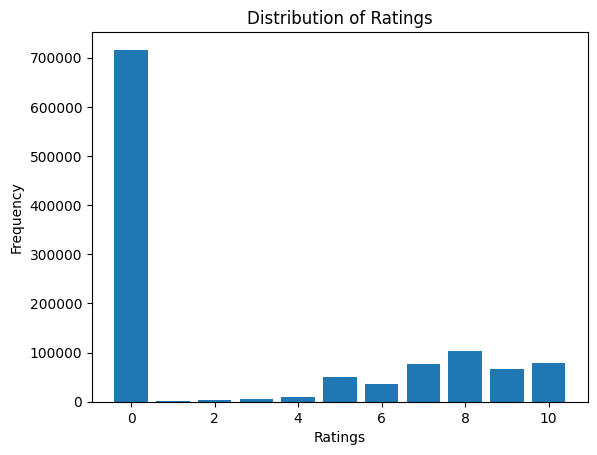

In [ ]:
ratings_group = ratings_df.groupby('Book-Rating').size()
plt.bar(ratings_group.index,ratings_group.values)
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')

In [ ]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [ ]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 266739 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 266739 non-null  object
 1   Book-Title           266739 non-null  object
 2   Book-Author          266737 non-null  object
 3   Year-Of-Publication  266739 non-null  int64 
 4   Publisher            266737 non-null  object
dtypes: int64(1), object(4)
memory usage: 12.2+ MB


In [ ]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69301 entries, 4 to 278855
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   User-ID  69301 non-null  float64
 1   Age      69301 non-null  int64  
 2   City     69301 non-null  object 
 3   State    69301 non-null  object 
 4   Country  69301 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 3.2+ MB


#### Merging Users,Books,Ratings dataframe for our dataset

In [ ]:
dataset = ratings_df.merge(books_df,on = 'ISBN').merge(users_df,how='inner',on='User-ID')
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132920 entries, 0 to 132919
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   User-ID              132920 non-null  int64 
 1   ISBN                 132920 non-null  object
 2   Book-Rating          132920 non-null  int64 
 3   Book-Title           132920 non-null  object
 4   Book-Author          132919 non-null  object
 5   Year-Of-Publication  132920 non-null  int64 
 6   Publisher            132920 non-null  object
 7   Age                  132920 non-null  int64 
 8   City                 132920 non-null  object
 9   State                132920 non-null  object
 10  Country              132920 non-null  object
dtypes: int64(4), object(7)
memory usage: 11.2+ MB


#### Dropping the duplicate user-ID and ISBN rows as a user can have only one rating per book.

In [ ]:
dataset = dataset.drop_duplicates(['User-ID','ISBN'],keep='first')
dataset.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
0,77940,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,34,melaka,melaka,malaysia
1,77940,0671793489,0,All Around the Town,Mary Higgins Clark,1993,Pocket Star,34,melaka,melaka,malaysia
2,77940,0553586122,0,Reap the Wind,Iris Johansen,2002,Bantam Books,34,melaka,melaka,malaysia
3,77940,055358068X,0,The Least Likely Bride,Jane Feather,2000,Bantam,34,melaka,melaka,malaysia
4,77940,0743422732,0,High Country Bride (McKettrick Cowboys),Linda Lael Miller,2002,Pocket,34,melaka,melaka,malaysia


In [ ]:
dataset[['Book-Rating','Book-Author','Year-Of-Publication','Publisher','Age','City','State','Country']].sample(10)

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
100471,8,Stef Ann Holm,1994,Pocket,49,samieira,pontevedra,spain
90841,9,Suzanne North,1997,McClelland &amp; Stewart,34,ottawa,ontario,canada
101378,0,Chinua Achebe,1996,Heinemann,23,hertfordshire,england,united kingdom
119762,9,Naomi Klein,2001,"Paidc\s Argentina""",40,alzira,valencia,spain
131528,5,Chris Madsen,1997,Dorling Kindersley,16,leicester,england,united kingdom
97151,5,Ian Fleming,1994,Random House Children's Books,34,kyiv,kyiv,ukraine
33670,0,Antonin Artaud,2004,Ivan R. Dee Publisher,20,maia,porto,portugal
64428,4,Anita Shreve,1999,Back Bay Books,39,dunnville,ontario,canada
7412,0,Dan Brown,2001,Pocket Star,23,guildford,surrey,united kingdom
74287,0,Flint Dille,1986,T S R,24,espoo,uusimaa,finland


#### Selecting the required columns for training

In [ ]:
recomendation_dataset = dataset[['Book-Rating','Book-Author','Year-Of-Publication','Publisher','Age','City','State','Country']].copy()
recomendation_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132920 entries, 0 to 132919
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Book-Rating          132920 non-null  int64 
 1   Book-Author          132919 non-null  object
 2   Year-Of-Publication  132920 non-null  int64 
 3   Publisher            132920 non-null  object
 4   Age                  132920 non-null  int64 
 5   City                 132920 non-null  object
 6   State                132920 non-null  object
 7   Country              132920 non-null  object
dtypes: int64(3), object(5)
memory usage: 8.1+ MB


#### Label encoding all catecorical columns

In [ ]:
encoder = LabelEncoder()
for column in recomendation_dataset.columns:
    if recomendation_dataset[column].dtype == object:
        recomendation_dataset[column] = encoder.fit_transform(recomendation_dataset[column])


In [ ]:
recomendation_dataset

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
0,0,19612,2002,509,34,1645,405,50
1,0,21072,1993,4719,34,1645,405,50
2,0,12763,2002,521,34,1645,405,50
3,0,13844,2000,519,34,1645,405,50
4,0,18838,2002,4712,34,1645,405,50
...,...,...,...,...,...,...,...,...
132915,0,12627,2003,1889,24,2885,15,76
132916,0,14219,2001,2420,50,2909,757,79
132917,6,16965,2004,6340,41,59,496,16
132918,0,29771,2000,231,27,2675,706,6


#### Normalizing every column to range between 0 and 1

In [ ]:
def normalizer(data,min,max):
    return (data - min) / (max - min)

In [ ]:
for column in recomendation_dataset.columns:
    min = recomendation_dataset[column].min()
    max = recomendation_dataset[column].max()
    recomendation_dataset[column] = recomendation_dataset[column].apply(normalizer,args=(min,max))


In [ ]:
recomendation_dataset

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
0,0.0,0.603799,0.675676,0.076118,0.3000,0.565486,0.535007,0.549451
1,0.0,0.648748,0.614865,0.705698,0.3000,0.565486,0.535007,0.549451
2,0.0,0.392937,0.675676,0.077912,0.3000,0.565486,0.535007,0.549451
3,0.0,0.426218,0.662162,0.077613,0.3000,0.565486,0.535007,0.549451
4,0.0,0.579970,0.675676,0.704651,0.3000,0.565486,0.535007,0.549451
...,...,...,...,...,...,...,...,...
132915,0.0,0.388750,0.682432,0.282488,0.1750,0.991750,0.019815,0.835165
132916,0.0,0.437764,0.668919,0.361896,0.5000,1.000000,1.000000,0.868132
132917,0.6,0.522305,0.689189,0.948108,0.3875,0.020282,0.655218,0.175824
132918,0.0,0.916567,0.662162,0.034545,0.2125,0.919560,0.932629,0.065934


#### KMeans

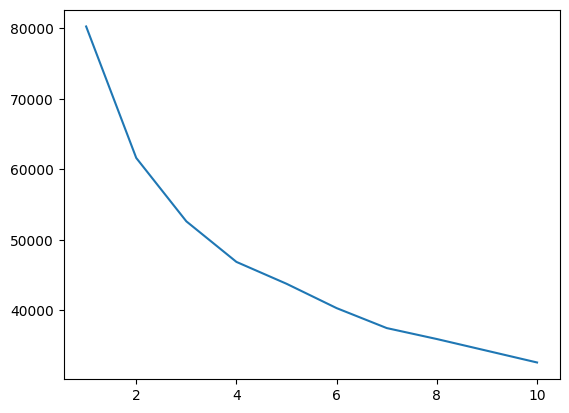

In [ ]:
inertias = []
for i in range(1,11):
    km = KMeans(n_clusters = i,n_init = 'auto')
    km.fit(recomendation_dataset)
    inertias.append(km.inertia_)
plt.plot(range(1,11),inertias)


In [ ]:
kmeans = KMeans(n_clusters= 5,n_init = 'auto')
clusters = kmeans.fit_predict(recomendation_dataset)


#### Appending cluster values back to our training dataset

In [ ]:
recomendation_dataset['Clusters'] = clusters

In [ ]:
recomendation_dataset['Clusters'].value_counts()

Clusters
3    35970
0    26480
4    26203
2    26030
1    18237
Name: count, dtype: int64

In [ ]:
recomendation_dataset

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country,Clusters
0,0.0,0.603799,0.675676,0.076118,0.3000,0.565486,0.535007,0.549451,0
1,0.0,0.648748,0.614865,0.705698,0.3000,0.565486,0.535007,0.549451,0
2,0.0,0.392937,0.675676,0.077912,0.3000,0.565486,0.535007,0.549451,0
3,0.0,0.426218,0.662162,0.077613,0.3000,0.565486,0.535007,0.549451,0
4,0.0,0.579970,0.675676,0.704651,0.3000,0.565486,0.535007,0.549451,0
...,...,...,...,...,...,...,...,...,...
132915,0.0,0.388750,0.682432,0.282488,0.1750,0.991750,0.019815,0.835165,0
132916,0.0,0.437764,0.668919,0.361896,0.5000,1.000000,1.000000,0.868132,0
132917,0.6,0.522305,0.689189,0.948108,0.3875,0.020282,0.655218,0.175824,4
132918,0.0,0.916567,0.662162,0.034545,0.2125,0.919560,0.932629,0.065934,3


#### Selecting training and test data

In [ ]:
train_df,test_df = recomendation_dataset.iloc[:,:-1],recomendation_dataset.iloc[:,-1]

#### Splitting training and testing dataset

In [ ]:
train_X,test_x,train_y,test_y = train_test_split(train_df,test_df,test_size=0.2)

#### ROCCHIO CLASSIFIER

#### Creating an instance of Rocchio classifier

In [ ]:
rocchio_clf = NearestCentroid()
rocchio_clf.fit(train_X,train_y)

NearestCentroid()

#### Checking the correctness and accuracy of rocchio method using cross validation

In [ ]:
print(cross_val_score(rocchio_clf,train_df,test_df,cv = 5))

[0.99680259 0.99924767 0.99834487 0.99488414 0.99691544]


#### Predicting results

In [ ]:
pred_y = rocchio_clf.predict(test_x)

In [ ]:
accuracy_score(test_y,pred_y) * 100

99.9473367439061

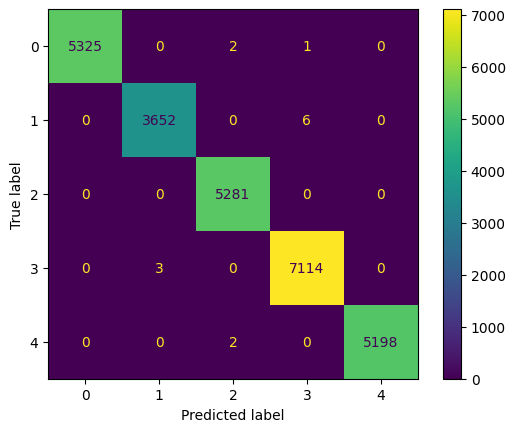

In [ ]:
cm = confusion_matrix(test_y,pred_y)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

#### Taking some samples for recomendation

In [ ]:
samples = test_x.sample(10)
samples

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
102392,0.8,0.500754,0.675676,0.096755,0.1625,0.901341,0.907530,0.615385
23407,0.7,0.025153,0.689189,0.346643,0.3000,0.115504,0.655218,0.175824
79989,0.0,0.676488,0.540541,0.400179,0.3750,0.525610,0.261559,0.956044
65031,0.0,0.446353,0.662162,0.058322,0.1500,0.673084,0.655218,0.175824
93324,0.8,0.566577,0.675676,0.939883,0.3000,0.673084,0.655218,0.175824
107781,0.0,0.825960,0.628378,0.843876,0.2875,0.643176,0.261559,0.956044
70905,0.7,0.370832,0.682432,0.904890,0.3125,0.063596,0.179657,0.835165
83210,0.9,0.400080,0.655405,0.432182,0.2625,0.832245,0.841480,0.857143
10393,0.0,0.623318,0.662162,0.394497,0.3000,0.340323,0.376486,0.351648
64880,1.0,0.747514,0.662162,0.976073,0.1875,0.517360,0.475561,0.747253


In [ ]:
indeces = samples.index.tolist()
indeces

[102392, 23407, 79989, 65031, 93324, 107781, 70905, 83210, 10393, 64880]

#### Predicting cluster values for our sample values

In [ ]:
samples_pred = rocchio_clf.predict(samples).reshape(1,-1).flatten().tolist()
samples_pred

[4, 4, 0, 3, 4, 0, 2, 4, 1, 2]

In [ ]:
data = train_X.copy()

In [ ]:
data['Clusters'] = train_y

In [ ]:
data

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country,Clusters
45915,0.0,0.706259,0.648649,0.463287,0.3000,0.758680,0.620872,0.329670,3
115165,0.0,0.258674,0.668919,0.591147,0.3000,0.566518,0.931308,0.054945,3
85420,0.0,0.173732,0.641892,0.538208,0.2125,0.566518,0.931308,0.054945,3
8855,0.9,0.141036,0.587838,0.038134,0.2375,0.023719,0.475561,0.747253,2
5737,0.0,0.918783,0.662162,0.770899,0.1750,0.673084,0.655218,0.175824,3
...,...,...,...,...,...,...,...,...,...
75761,0.7,0.362396,0.662162,0.144609,0.3250,0.634239,0.305152,0.615385,2
30806,0.0,0.011976,0.668919,0.096755,0.2875,0.447920,0.797886,0.549451,3
11908,0.2,0.498322,0.655405,0.460296,0.3000,0.269165,0.019815,0.175824,1
86273,0.8,0.904991,0.601351,0.318528,0.2000,0.566518,0.931308,0.054945,4


In [ ]:
samples

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
102392,0.8,0.500754,0.675676,0.096755,0.1625,0.901341,0.907530,0.615385
23407,0.7,0.025153,0.689189,0.346643,0.3000,0.115504,0.655218,0.175824
79989,0.0,0.676488,0.540541,0.400179,0.3750,0.525610,0.261559,0.956044
65031,0.0,0.446353,0.662162,0.058322,0.1500,0.673084,0.655218,0.175824
93324,0.8,0.566577,0.675676,0.939883,0.3000,0.673084,0.655218,0.175824
107781,0.0,0.825960,0.628378,0.843876,0.2875,0.643176,0.261559,0.956044
70905,0.7,0.370832,0.682432,0.904890,0.3125,0.063596,0.179657,0.835165
83210,0.9,0.400080,0.655405,0.432182,0.2625,0.832245,0.841480,0.857143
10393,0.0,0.623318,0.662162,0.394497,0.3000,0.340323,0.376486,0.351648
64880,1.0,0.747514,0.662162,0.976073,0.1875,0.517360,0.475561,0.747253


#### Grouping books for recommending books on popular and highest average rating basis

In [ ]:
books_rate_df = dataset.groupby('Book-Title')

In [ ]:
pk.dump(dataset, open('dataset.pkl','wb'))
# pk.dump(books_rate_df, open('books_rate_df.pkl','wb'))


#### Filtering popular books

In [ ]:
def popular_books():
    return books_rate_df.size().sort_values(ascending=False).head(10).index

In [ ]:
print('------- Here are some of the popular books you may like -------')
print('-----Happy Reading!!!-------')
pd.Series(popular_books())


------- Here are some of the popular books you may like -------
-----Happy Reading!!!-------


0                                Wild Animus
1                  The Lovely Bones: A Novel
2                      Bridget Jones's Diary
3                                 Life of Pi
4                                   Chocolat
5    The Girls' Guide to Hunting and Fishing
6                          The Da Vinci Code
7                                About a Boy
8                          The Joy Luck Club
9                     Snow Falling on Cedars
Name: Book-Title, dtype: object

#### Filtering books on highest average ratings

In [ ]:
def highest_rated_books():
    return books_rate_df['Book-Rating'].mean().sort_values(ascending=False).head(10).index

In [ ]:
print('------- Here are some of the highest rated books you may like -------')
print('-----Happy Reading!!!-------')
pd.Series(highest_rated_books())


------- Here are some of the highest rated books you may like -------
-----Happy Reading!!!-------


0                                                                                             Pastoral Americana
1               Mercer Mayer's LC + The Critter Kids:  Showdown at the Arcade (A Golden Book School Time Reader)
2                                                                                 McEnroe: A Rage for Perfection
3                                                                                      McKnight in Shining Armor
4                                                              Doktorspiele. GestÃ?Â¤ndnisse eines Hochstaplers.
5                                                                                                           Goya
6                                                                     Bob Saves the Porcupines (Bob The Builder)
7                                                                                       Alistair Cooke's America
8    Seasons for Celebration: A Contemporary Guide to the Joys, Practices, and Traditions of the

####User based Recommendation

#### Using KNN classifier on the predicted values of rocchio on our sample data for recommendation.¶

In [ ]:
for i in range(len(indeces)):
    knn_dataset = data[data['Clusters']==samples_pred[i]]
    knn_dataset = knn_dataset.reset_index()
    knn = NearestNeighbors()
    knn.fit(knn_dataset.iloc[:,1:-1])
    neighbors = knn.kneighbors(pd.DataFrame(samples.loc[indeces[i]]).T,5,return_distance = False)
    print("\n------------Your Review-------------\n")
    display(pd.DataFrame(dataset.loc[indeces[i],'ISBN':]).T)
    print(f"\n------------Here are few recomendations based on your review that you may like-------------\n")
    recomendations = pd.DataFrame(columns = dataset.columns)

    for j in neighbors:
        display(pd.DataFrame(dataset.loc[knn_dataset.loc[j]['index'],['Book-Title','Book-Author','Year-Of-Publication','Publisher','City','State','Country']]))
    print("\n------------End-------------\n")



------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
102392,0425184498,8,The Boy Next Door,Josie Lloyd,2002,Berkley Publishing Group,23,utrecht,utrecht,netherlands



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
107627,Think Dog!,John Fisher,2001,Cassell Illustrated,zeist,utrecht,netherlands
94025,The Heartsong of Charging Elk : A Novel,JAMES WELCH,2001,Anchor,utrecht,utrecht,netherlands
78878,Chocolat,Joanne Harris,2000,Black Swan,wellington,wellington,new zealand
127307,The Dark Clue: A Novel of Suspense,James Wilson,2001,Atlantic Monthly Press,utrecht,utrecht,netherlands
75082,250 Essential Kanji for Everyday Use (Tuttle Language Library),Kanji Text Research Group,1993,Charles E. Tuttle Co.,tokyo,tokyo,japan



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
23407,0883656442,7,The Best of Mystery : 63 Short Stories Chosen By The Master of Suspense,Alfred Hitchcock,2004,Galahad,34,brampton,ontario,canada



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
56147,The Bean Trees,Barbara Kingsolver,1998,HarperTorch,brooklin,ontario,canada
23487,Tales of Terror : 58 Short Stories Chosen by the Master of Suspense,Alfred Hitchcock,2004,Galahad,brampton,ontario,canada
46662,Looking Back,Belva Plain,2002,Dell Publishing Company,cambridge,ontario,canada
101656,Three Weeks in Paris,BARBARA TAYLOR BRADFORD,2002,Dell,burlington,ontario,canada
23550,Alfred Hitchcock: Portraits of Murder (Alfred Hitchcock Mysteries (Hardcover)),Alfred Hitchcock,1989,Galahad Books,brampton,ontario,canada



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
79989,0004116941,0,Collins Encyclopedia of Fishing in Britain and Ireland,Michael Prichard,1982,HarperCollins Publishers,40,london,england,united kingdom



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
19673,I Am a Mouse,Ole Risom,1984,Goldencraft,london,england,united kingdom
79953,The Colours of Space,Marion Zimmer Bradley,1989,Hodder &amp; Stoughton General Division,london,england,united kingdom
19572,Hawksmoor,Peter Ackroyd,1986,Harpercollins,london,england,united kingdom
19495,The Incredible Adventure of Professor Branestawm (Large Print Series),Norman Hunter,1991,G. K. Hall &amp; Company,london,england,united kingdom
6196,In Safekeeping,Naomi Horton,1991,Harlequin Mills &amp; Boon Ltd,london,england,united kingdom



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
65031,0671042556,0,Blackbird: A Childhood Lost and Found,Jennifer Lauck,2000,Atria,22,ottawa,ontario,canada



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
109463,Tom Clancy's Op-Center: Line of Control (Tom Clancy's Op Center (Paperback)),Jeff Rovin,2001,Berkley Publishing Group,ottawa,ontario,canada
5614,Rattlesnake Crossing,J.A. Jance,1999,Avon,ottawa,ontario,canada
5754,The Prettiest Feathers,John Philpin,1997,Bantam Books,ottawa,ontario,canada
5490,Manhattan Hunt Club,JOHN SAUL,2002,Ballantine Books,ottawa,ontario,canada
5745,"Love Comes Softly (Oke, Janette, Love Comes Softly Series, Bk. 1,)",Janette Oke,2003,Bethany House Publishers,ottawa,ontario,canada



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
93324,0812967658,8,"Does This Make Me Look Fat?: The Definitive Rules for Dressing Thin for Every Height, Size, and Shape",Leah Feldon,2002,Villard Books,34,ottawa,ontario,canada



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
98551,The Boy Who Lost His Face,LOUIS SACHAR,1997,Yearling,perth,ontario,canada
122372,When I Think of You,Liz Ireland,2002,Zebra Books,newmarket,ontario,canada
12555,A Body to Die For,Kate White,2003,Warner Books,ottawa,ontario,canada
3983,The Diviners,Margaret Laurence,1993,University of Chicago Press,ottawa,ontario,canada
104982,Speak,Laurie Halse Anderson,2001,Speak,ottawa,ontario,canada



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
107781,0671886908,0,"The Laertian Gamble (Star Trek Deep Space Nine, No 12)",Robert Scheckley,1995,Star Trek,33,norwich,england,united kingdom



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
107776,Sex &amp; Drugs &amp; Sausage Rolls,Robert Rankin,2000,Transworld Publishers Limited,norwich,england,united kingdom
38452,"The Captain's Daughter (Star Trek, Book 76)",Peter David,1995,Star Trek,northamptonshire,england,united kingdom
107780,Imzadi (Star Trek: The Next Generation),Peter David,1993,Star Trek,norwich,england,united kingdom
38427,"The Subtle Knife (His Dark Materials, Book 2)",Philip Pullman,1998,Scholastic Point,northamptonshire,england,united kingdom
38458,The Tiger in the Well,Philip Pullman,1999,Scholastic Ltd,northamptonshire,england,united kingdom



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
70905,8483102374,7,LA Leona Blanca/the White Lioness (Andanzas),Henning Mankell,2003,Tusquets,35,barcelona,catalunya,spain



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
70904,Los Perros De Riga (Andanzas),Henning Mankell,2002,Tusquets,barcelona,catalunya,spain
70892,El Puerto De Las Brumas,Georges Simenon,2002,Tusquets,barcelona,catalunya,spain
22096,Hopper (Big Art Series),Ivo Kranzfelder,1998,Taschen,barcelona,catalunya,spain
22115,El Silmarillion,J. R. R. Tolkien,2001,"Sage, Evelyn/editorial Molino",barcelona,catalunya,spain
22076,Five Past Midnight in Bhopal: The Epic Story of the World's Deadliest Industrial Disaster,Javier Moro,2003,Warner Books,barcelona,catalunya,spain



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
83210,0618009345,9,Poems from The Hobbit,J. R. R. Tolkien,1999,Houghton Mifflin,31,stockholm,stockholm,sweden



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
102502,Turning Your Adversity Into Victory,Jerry Savelle,1994,Harrison House,singapore,singapore,singapore
54663,Mars sucht Venus. Venus sucht Mars. Wie Sie Ihren SeelengefÃ?Â¤hrten erkennen.,John Gray,2000,Goldmann,schaffhausen,schaffhausen,switzerland
54531,The Pirate Next Door,Jennifer Ashley,2003,Leisure Books,stockholm,stockholm,sweden
130027,Hope and Glory,Katherine Sutcliffe,1999,Jove Books,singapore,singapore,singapore
82939,The Descent,Jeff Long,2001,Jove Books,singapore,singapore,singapore



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
10393,0373036078,0,"Bridesmaid'S Wedding (Legends Of The Outback) (Harlequin Romance, 3607)",Margaret Way,2000,Harlequin,34,ginsheim,hessen,germany



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
10200,"Forever And A Baby (The Midwives) (Superromance, 912)",Margot Early,2000,Harlequin,ginsheim,hessen,germany
9895,"Bodyguard'S Assignment (Texas Confidential) (Intrigue, 581)",Mark Stevens,2000,Harlequin,ginsheim,hessen,germany
10502,"Somebody'S Baby (Lost And Found) (Harlequin Intrigue, 489)",Mark Stevens,1998,Harlequin,ginsheim,hessen,germany
9865,"The Courtship (Harlequin Historical, No. 613)",Lynna Banning,2002,Harlequin,ginsheim,hessen,germany
10902,"The Courtship (Harlequin Historical, No. 613)",Lynna Banning,2002,Harlequin,ginsheim,hessen,germany



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
64880,0786916354,10,Descent into the Depths of the Earth (Greyhawk),Paul Kidd,2000,Wizards of the Coast,25,lisboa,lisboa,portugal



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
64877,White Plume Mountain (Greyhawk),Paul Kidd,1999,Wizards of the Coast,lisboa,lisboa,portugal
64891,Queen of the Demonweb Pits (Greyhawk Classics),Paul Kidd,2001,Wizards of the Coast,lisboa,lisboa,portugal
64869,"Siege of Darkness (Forgotten Realms: Legacy of the Drow, Book 3)",R. A. Salvatore,1999,Wizards of the Coast,lisboa,lisboa,portugal
25652,The Other Boleyn Girl,Philippa Gregory,2002,Touchstone,lisboa,lisboa,portugal
129604,Nobody's Fool,Richard Russo,1998,Vintage,madrid,madrid,spain



------------End-------------



# ------------ Sameer Gururaj Contribution End ------------

# ------------ Sweta Samala Contribution ------------

#### Recommender System on Age based

In [ ]:
age_recommend_dataset = dataset[['Book-Title','Age']].copy()

In [ ]:
def categorize_age(age):
    if(age>=10 and age <=30):
        return 'young'
    elif age>30 and age<=60:
        return "mid-age"
    else: return "old"

In [ ]:
age_recommend_dataset['Age-Group'] = age_recommend_dataset['Age'].apply(categorize_age)
age_recommend_dataset

,Book-Title,Age,Age-Group
0,Flesh Tones: A Novel,34,mid-age
1,All Around the Town,34,mid-age
2,Reap the Wind,34,mid-age
3,The Least Likely Bride,34,mid-age
4,High Country Bride (McKettrick Cowboys),34,mid-age
...,...,...,...
132915,El Tiempo de Las Mujeres (Narrativas Hispanicas),24,young
132916,"Ich, Prinzessin aus dem Hause Al Saud / Ich, Prinzessin Sultana, und meine TÃ?Â¶chter.",50,mid-age
132917,The Honey Wall: A Novel,41,mid-age
132918,Sieben Generationen Wahnsinn.,27,young


In [ ]:
pk.dump(age_recommend_dataset, open('age_recommend_dataset.pkl','wb'))

In [ ]:
## Created a function which takes the age and recommends books from the data set as per the age-group

def age_based_recomendation(age,group):
    age_data = age_recommend_dataset[age_recommend_dataset['Age-Group'] == group]
    age_data = age_data.reset_index()
    result = []
    for i in range(age_data.shape[0]):
        #column 2 = Age column
        diff = abs(age_data.iloc[i,2] - age)
        result.append([age_data.iloc[i,0],diff])
    result.sort(key = lambda x: x[1])
    age_data = []
    for i in range(10):
        age_data.append(result[i][0])
    return age_data


In [ ]:
age = 26
# Uncomment below line to enter age of you convinient
# age = int(input('Enter you age'))
if(age<=30):
    age_data = age_based_recomendation(age,'young')
elif(age>=30 and age<=60):
    age_data = age_based_recomendation(age,'mid-age')
else:
    age_data = age_based_recomendation(age,'old')
print("-------Here are some books people of your age are reading along------")
display(dataset.iloc[age_data]['Book-Title'])

-------Here are some books people of your age are reading along------


4547                                                     Lightning
4548                                     The Lovely Bones: A Novel
4549                                             The Joy Luck Club
4550                                                   Wild Animus
4551    Dragons of Autumn Twilight (Dragonlance Chronicles, Vol 1)
4552                                     The Bonesetter's Daughter
4553                                             Girl, Interrupted
4554                                        Me Talk Pretty One Day
4555                                              Escape the Night
4556                    A Time for Trolls: Fairy Tales from Norway
Name: Book-Title, dtype: object

### Collaborative Filtering

#### Item-Based Filtering using KNN

In [ ]:
# lets check ratings dataframe
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
# lets check the number of books each user rated:
ratings_df['User-ID'].value_counts()

User-ID
11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
          ...  
116180        1
116166        1
116154        1
116137        1
276723        1
Name: count, Length: 105283, dtype: int64

In [ ]:
x=ratings_df['User-ID'].value_counts() > 200
x[x].shape

(899,)

In [ ]:
y=x[x].index
y

Index([ 11676, 198711, 153662,  98391,  35859, 212898, 278418,  76352, 110973,
       235105,
       ...
       260183,  73681,  44296, 155916,   9856, 274808,  28634,  59727, 268622,
       188951],
      dtype='int64', name='User-ID', length=899)

In [ ]:
ratings_knn=ratings_df[ratings_df['User-ID'].isin(y)]
ratings_knn.head(5)

,User-ID,ISBN,Book-Rating
1456,277427,002542730X,10
1457,277427,0026217457,0
1458,277427,003008685X,8
1459,277427,0030615321,0
1460,277427,0060002050,0


In [ ]:
ratings_with_name = ratings_knn.merge(books_df,on='ISBN')
ratings_with_name.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc


In [ ]:
ratings_with_name['Book-Title'].unique().shape

(158319,)

#### Lets compute the total ratings of each book

In [ ]:
# lets compute the ratings of each book

num_rating_df = ratings_with_name.groupby('Book-Title')['Book-Rating'].count().reset_index()
print(num_rating_df.shape)
num_rating_df.head()

(158319, 2)


,Book-Title,Book-Rating
0,"A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)",2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance for the 1990s,1
4,Clifford Visita El Hospital (Clifford El Gran Perro Colorado),1


In [ ]:
# Renaming the column as num_of_ratings

num_rating_df.rename(columns={'Book-Rating': 'num_of_ratings'},inplace=True)
num_rating_df.head()

,Book-Title,num_of_ratings
0,"A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)",2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance for the 1990s,1
4,Clifford Visita El Hospital (Clifford El Gran Perro Colorado),1


#### Lets filter out books with ratings greater than 50, coz the one with number of ratings as '1' wont give us sufficient info

In [ ]:
final_rating = ratings_with_name.merge(num_rating_df,on='Book-Title')
#final_rating.rename(columns={'Book-Rating_y':'num_of_rating'},inplace=True)
final_rating.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,num_of_ratings
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc,82


In [ ]:
final_rating=final_rating[final_rating['num_of_ratings']>=50]
final_rating.head(5)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,num_of_ratings
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc,82


#### Dropping duplicate values of user-id and title

In [ ]:
final_rating.drop_duplicates(['User-ID','Book-Title'], inplace=True)

In [ ]:
final_rating.shape

(59507, 8)

In [ ]:
book_pivot = final_rating.pivot_table(columns='User-ID',index='Book-Title', values='Book-Rating')

In [ ]:
book_pivot

User-ID,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1st to Die: A Novel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2nd Chance,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
4 Blondes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Bend in the Road,0.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
You Belong To Me,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


#### From the above table, we can see there are Nan values so lets fill it with '0'

In [ ]:
#lets fill nan with '0'

book_pivot.fillna(0, inplace=True)
book_pivot

User-ID,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bend in the Road,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
book_sparse =csr_matrix(book_pivot)

#### ************* Implementing the KNN *********************

In [ ]:
from sklearn.neighbors import NearestNeighbors
model=NearestNeighbors(algorithm='brute')


In [ ]:
model.fit(book_sparse)

NearestNeighbors(algorithm='brute')

In [ ]:
book_pivot.iloc[233,:].name

'Harry Potter and the Chamber of Secrets (Book 2)'

In [ ]:
distance,suggestion = model.kneighbors(book_pivot.iloc[233,:].values.reshape(1,-1), n_neighbors=10)

In [ ]:
distance

array([[ 0.        , 68.78953409, 69.5413546 , 72.64296249, 76.83098333,
        77.28518616, 77.59510294, 77.60154638, 77.65307463, 77.68526244]])

In [ ]:
suggestion

array([[233, 236, 234, 237, 180, 531, 670, 681, 684, 592]])

In [ ]:
# we need book names
for i in range(len(suggestion)):
    print(book_pivot.index[suggestion[i]])

Index(['Harry Potter and the Chamber of Secrets (Book 2)',
       'Harry Potter and the Prisoner of Azkaban (Book 3)',
       'Harry Potter and the Goblet of Fire (Book 4)',
       'Harry Potter and the Sorcerer's Stone (Book 1)', 'Exclusive',
       'The Cradle Will Fall', 'The Witness',
       'Tom Clancy's Op-Center (Tom Clancy's Op Center (Paperback))', 'Toxin',
       'The Long Road Home'],
      dtype='object', name='Book-Title')


In [ ]:
book_pivot.index[4]

'A Bend in the Road'

In [ ]:
book_pivot.index

Index(['1984', '1st to Die: A Novel', '2nd Chance', '4 Blondes',
       'A Bend in the Road', 'A Case of Need',
       'A Child Called \It\": One Child's Courage to Survive"',
       'A Civil Action', 'A Cry In The Night', 'A Darkness More Than Night',
       ...
       'Winter Solstice', 'Wish You Well', 'Without Remorse',
       'Wizard and Glass (The Dark Tower, Book 4)', 'Wuthering Heights',
       'Year of Wonders', 'You Belong To Me',
       'Zen and the Art of Motorcycle Maintenance: An Inquiry into Values',
       'Zoya', '\O\" Is for Outlaw"'],
      dtype='object', name='Book-Title', length=737)

In [ ]:
books_name = book_pivot.index

In [ ]:
def recommend_book(book_name):
    book_id=np.where(book_pivot.index == book_name)[0][0]
    distance,suggestion = model.kneighbors(book_pivot.iloc[book_id,:].values.reshape(1,-1), n_neighbors=10)

    for i in range(len(suggestion)):
        books = book_pivot.index[suggestion[i]]
        print("BELOW ARE THE RECOMMENDED BOOKS:  \n")
        for j in books:
            print(j)



In [ ]:
## Taking the book name
book_name= '1984'
recommend_book(book_name)

BELOW ARE THE RECOMMENDED BOOKS:  

1984
No Safe Place
A Civil Action
Foucault's Pendulum
Long After Midnight
Abduction
Master of the Game
Exclusive
The Terminal Man
Lake Wobegon days


#### Lets write a function which takes book-id and recommends nearest books

#### This is the output of ITEM BASED SYSTEM

#### ************** SVD ***************

#### Creation of Distance and SVD Functions:

In [ ]:
def euclidSim(inA,inB):
    return 1.0/(1.0 + np.linalg.norm(inA - inB))

def pearsonSim(inA,inB):
    if len(inA) < 3 : return 1.0
    return 0.5+0.5*np.corrcoef(inA, inB, rowvar = 0)[0][1]

def svdEst(dataMat, user, simMeas, item):
    n = np.shape(dataMat)[1]
    simTotal = 0.0; ratSimTotal = 0.0
    data=np.mat(dataMat)
    U,Sigma,VT = np.linalg.svd(data)
    Sig4 = np.mat(np.eye(4)*Sigma[:4]) #arrange Sig4 into a diagonal matrix
    xformedItems = data.T * U[:,:4] * Sig4.I  #create transformed items
    for j in range(n):
        userRating = data[user,j]
        if userRating == 0 or j==item: continue
        similarity = simMeas(xformedItems[item,:].T, xformedItems[j,:].T)
        #print('the %d and %d similarity is: %f' % (item, j, similarity))
        simTotal += similarity
        ratSimTotal += similarity * userRating
    if simTotal == 0: return 0
    else: return ratSimTotal/simTotal

#### Developed the ‘recommend’ function to generate book recommendations for a specific user by taking below parameter

In [ ]:
def recommend(dataMat, user, N=3, simMeas = pearsonSim, estMethod=svdEst):
    unratedItems = np.nonzero(dataMat[user,:].A==0)[1] #find unrated items
    if len(unratedItems) == 0: return 'you rated everything'
    itemScores = []
    for item in unratedItems:
        estimatedScore = estMethod(dataMat, user, simMeas, item)
        itemScores.append((item, estimatedScore))
    return sorted(itemScores, key=lambda jj: jj[1], reverse=True)[:N]

In [ ]:
data=np.mat(book_pivot.T)

#### Calling the function to get the recommendations to particular user

In [ ]:
user = 18
recommendations = recommend(data, user, N=5, simMeas=pearsonSim, estMethod=svdEst)
print(recommendations)


[(671, 9.150652915656469), (647, 9.150549475537883), (409, 9.150286404879852), (246, 9.150274334533846), (649, 9.149832966317652)]


#### Implemented a loop to iterate over the recommendations generated by the recommed function.

In [ ]:
print("Recommended Items for User", user, ":\n")
for i, p in recommendations:
    print(f'Book: "{book_pivot.index[i].title()}" , Rating : "{round(p,2)}"')

Recommended Items for User 18 :

Book: "The Woman Next Door" , Rating : "9.15"
Book: "The Summerhouse" , Rating : "9.15"
Book: "Reap The Wind" , Rating : "9.15"
Book: "Hemlock Bay" , Rating : "9.15"
Book: "The Surgeon" , Rating : "9.15"


**Save model to Pickle**

In [ ]:
pk.dump(model, open('model.pkl', 'wb'))
pk.dump(books_name, open('books_name.pkl', 'wb'))
pk.dump(final_rating, open('final_rating.pkl', 'wb'))
pk.dump(book_pivot, open('book_pivot.pkl', 'wb'))